In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", message="Adding an axes using the same arguments")
from scipy.stats import lomax
from collections import Counter
from scipy.stats import gamma
from scipy.stats import beta

In [6]:
%run -i MABs_KL_Functions
%run -i MABs_Env_Generations

In [21]:
class player_m:
    def __init__(self, n_arms, player_index, n_players, n_rounds):
        self.regrets = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []
        self.means = np.zeros(shape = n_arms)
        self.n_trials = np.zeros(shape = n_arms)
        self.choices = []
        self.all_rewards = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.all_trials = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.n_arms = n_arms
        self.player_index = player_index
        self.n_players = n_players
            
    def update_n_trials(self, choice, current_round):
        if choice != None:
            self.all_trials[choice, self.player_index, current_round] = 1
            self.n_trials[choice] += 1
               
    def receive_n_trials(self, other_trials):
        self.all_trials[(self.all_trials == 0) & (other_trials == 1)] = 1
        self.n_trials = self.all_trials.sum(axis = 2).sum(axis =  1)
                
    def receive_reward(self, other_reward):
        self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
        self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
                
    def update_mean(self, choice, reward, current_round):
        if choice != None:
            self.all_rewards[choice, self.player_index, current_round] = reward
            increment = (reward - self.means[choice])/self.n_trials[choice]
            self.means[choice] += increment
        
    def update_regret(self, reward, best_reward):
        regret = best_reward - reward
        self.regrets.append(regret)
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)

In [41]:
def multiple_experiment(n_arms, n_players, n_rounds, n_iterations, com_freqs, title, player_type, lambdas = None, beta = 1, conc = 0.5, dist = 'Dirichlet', temp = None, n_variables = None, scale = 1, shape = 1, d = None):
    if dist == 'Dirichlet':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, conc = conc)
        ranked_means = sorted(env.all_means)
        if player_type == 'thom':
            lb = 1
            ub = n_variables
    elif dist == 'Bernoulli':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, dist = dist)
        ranked_means = sorted(env.all_means)
        if player_type == 'thom':
            lb = 0
            ub = 1
        
    if player_type == 'thom':
        if dist == 'Exponential':
            ub = np.random.exponential(scale = np.max(lambdas), size = 1000).max()
            lb = np.random.exponential(scale = np.min(lambdas), size = 1000).min()
        elif dist == 'Poisson':
            ub = np.random.poisson(lam = np.max(lambdas), size = 1000).max()
            lb = np.random.poisson(lam = np.min(lambdas), size = 1000).min()
        elif dist == 'Dirichlet':
            ub = 10
            lb = 1
       
    trials = pd.DataFrame()
    for f in tqdm(range(len(com_freqs))):
        com_freq = com_freqs[f]
        all_regrets = np.zeros(shape = (n_iterations, n_rounds, n_players))
        all_choices = np.zeros(shape = (n_iterations, n_rounds, n_players))
        
        for j in range(n_iterations):
            choices_rank = np.zeros(shape = (n_rounds, n_players))
            all_players = []
            for i in range(n_players):
                if player_type == 'ucb1':
                    player = ucb_1_player(n_arms = n_arms, beta = beta, player_index = i, n_players = n_players, n_rounds = n_rounds)
                elif player_type == 'ucbv':
                    player = ucb_v_player(n_arms = n_arms, beta = beta, player_index = i, n_players = n_players, n_rounds = n_rounds)
                elif player_type == 'moss':
                    player = ucb_moss_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, beta = beta)
                elif player_type == 'ucbkl':
                    player = ucb_kl_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist)
                elif player_type == 'soft-eps':
                    player = soft_eps_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, temp = temp)
                elif player_type == 'bayes':
                    player = bayes_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist, scale = scale, shape = shape)
                elif player_type == 'thom':
                    player = thom_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, dist = dist, lb = lb, ub = ub)
                elif player_type == 'eps':
                    player = eps_player(n_arms = n_arms, player_index = i, n_players = n_players, n_rounds = n_rounds, prob = decay_prob(d))
                all_players.append(player)
            counter = 0
            for i in range(1, n_rounds + 1):
                choices = [None for i in range(n_players)]
                rewards = np.zeros(shape = n_players)
                if i <= all_players[0].n_arms:
                    choices = [i-1 for j in range(n_players)]
                    for n in range(n_players):
                        all_players[n].choices.append(choices[n])
                else:
                    for n in range(n_players):
                        if i in com_freq:
                            all_players[n].choices.append(None)
                            for m in range(n_players):
                                if j != m:
                                    all_players[n].receive_n_trials(all_players[m].all_trials)
                                    all_players[n].receive_reward(all_players[m].all_rewards)
                                    counter += 1
                        else:
                            if player_type == 'ucbkl':
                                all_players[n].compute_ucbs(i, l_rate = 0.01, max_iter = 100000)
                            elif player_type in ['ucb1', 'ucbv', 'moss', 'bayes']:
                                all_players[n].compute_ucbs(i)
                            elif player_type == 'soft-eps' or player_type == 'eps':
                                exp = all_players[n].exp_vs_exp(i)
                                
                            if player_type == 'soft-eps' or player_type == 'eps':
                                choices[n] = all_players[n].choice(exp)
                            else:
                                choices[n] = all_players[n].choice()
                                
                if dist == 'Dirichlet' or dist == 'Bernoulli':
                    for p in range(len(choices)):
                        if choices[p] != None:
                            choices_rank[i-1, p] = ranked_means.index(env.all_means[choices[p]])
                        else:
                            choices_rank[i-1, p] = None
                                                                      
                for k in range(n_players):
                    if choices[k] != None:
                        if dist == 'Dirichlet' or dist == 'Bernoulli':
                            rewards[k] = np.random.choice(env.rewards, p = env.probs_matrix[choices[k], :])
                            best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                        elif dist == 'Poisson':
                            rewards[k] = np.random.poisson(lam = lambdas[choices[k]])
                            best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                        elif dist == 'Exponential':
                            rewards[k] = np.random.exponential(scale = lambdas[choices[k]])
                            best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])

                for h in range(n_players):
                    all_players[h].update_n_trials(choices[h], i-1)
                    all_players[h].update_mean(choices[h], rewards[h], i-1)
                    if player_type == 'ucbv':
                        all_players[h].update_variance(choices[h])
                    if player_type == 'bayes':
                        all_players[h].update_params(choices[h], rewards[h])
                    if player_type == 'thom':
                        if dist != 'Bernoulli':
                            norm_reward = all_players[h].normalize(rewards[h])
                            all_players[h].update_params(choices[h], norm_reward)
                        else:
                            all_players[h].update_params(choices[h], rewards[h])
                    all_players[h].update_regret(rewards[h], best_reward)

            for l in range(n_players):
                all_regrets[j, :, l] = all_players[l].cumulative_regrets
                if dist == 'Bernoulli' or dist == 'Dirichlet':
                    all_choices[j, : , l] = choices_rank[:, l]
                else:
                    all_choices[j, : , l] = all_players[l].choices

        for i in range(n_players):
            trials[f'p{i+1}_{com_freq[0]}_regrets'] = all_regrets[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_choices'] = all_choices[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_stds'] = all_regrets[:, :, i].std(axis = 0)

    trials.to_csv(f'{n_players}_{title}.csv')

In [125]:
class player_m_2:
    def __init__(self, n_arms, player_index, n_players, n_rounds):
        self.regrets = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []
        self.means = np.zeros(shape = n_arms)
        self.n_trials = np.zeros(shape = n_arms)
        self.choices = []
        self.all_rewards = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.all_trials = np.zeros(shape = (n_arms, n_players, n_rounds))
        self.n_arms = n_arms
        self.player_index = player_index
        self.n_players = n_players
            
    def update_n_trials(self, choice, current_round):
        if choice != None:
            self.all_trials[choice, self.player_index, current_round] = 1
            self.n_trials[choice] += 1
               
    def receive_n_trials(self, other_trials):
        self.all_trials[(self.all_trials == 0) & (other_trials == 1)] = 1
        self.n_trials = self.all_trials.sum(axis = 2).sum(axis =  1)
                
    def receive_info_all(self, other_means, other_n_trials):
        weights_self = self.n_trials/(self.n_trials + other_n_trials)
        weights_other = other_n_trials/(self.n_trials + other_n_trials)
        self.means = self.means*weights_self + other_means*weights_other
        self.n_trials += other_n_trials
        
    def receive_info_single(self, other_means, other_n_trials, index):
        weights_self = self.n_trials[index]/(self.n_trials[index] + other_n_trials[index])
        weights_other = other_n_trials[index]/(self.n_trials[index] + other_n_trials[index])
        self.means[index] = self.means*weights_self + other_means*weights_other
        self.n_trials[index] += other_n_trials[index]
                
    def update_mean(self, choice, reward, current_round):
        if choice != None:
            self.all_rewards[choice, self.player_index, current_round] = reward
            increment = (reward - self.means[choice])/self.n_trials[choice]
            self.means[choice] += increment
        
    def update_regret(self, reward, best_reward):
        regret = best_reward - reward
        self.regrets.append(regret)
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)

# UCB 1

In [126]:
class ucb_1_player(player_m_2):
    def __init__(self, n_arms, beta, player_index, n_players, n_rounds):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.ucbs = np.zeros(shape = n_arms)
        self.beta = beta
        
    def compute_ucbs(self, current_round):
        self.ucbs[self.n_trials > 0] = np.sqrt(2*(self.beta**2)*np.log(current_round)/self.n_trials[self.n_trials > 0])
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice

In [127]:
def multiple_ucb_1(n_arms, n_players, n_rounds, n_iterations, com_freqs, title, lambdas = None, beta = 1, conc = 0.5, dist = 'Dirichlet', n_variables = None):
    if dist == 'Dirichlet':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, conc = conc)
    if dist == 'Bernoulli':
        env = env_generation(n_arms = n_arms, n_variables = n_variables, dist = dist)
        
    trials = pd.DataFrame()
    for f in tqdm(range(len(com_freqs))):
        com_freq = com_freqs[f]
        all_regrets = np.zeros(shape = (n_iterations, n_rounds, n_players))
        all_choices = np.zeros(shape = (n_iterations, n_rounds, n_players))
        
        for j in range(n_iterations):
            all_players = []
            for i in range(n_players):
                player = ucb_1_player(n_arms = n_arms, beta = beta, player_index = i, n_players = n_players, n_rounds = n_rounds)
                all_players.append(player)

            counter = 0
            for i in range(1, n_rounds + 1):
                choices = [None for i in range(n_players)]
                rewards = np.zeros(shape = n_players)
                if i <= all_players[0].n_arms:
                    choices = [i-1 for j in range(n_players)]
                    for n in range(n_players):
                        all_players[n].choices.append(choices[n])
                else:
                    for n in range(n_players):
                        if i in com_freq:
                            all_players[n].choices.append(None)
                            for m in range(n_players):
                                if j != m:
                                    all_players[n].receive_info_all(all_players[m].means, all_players[m].n_trials)
                                    counter += 1
                        else:
                            all_players[n].compute_ucbs(i)
                            choices[n] = all_players[n].choice()

                for k in range(n_players):
                    if choices[k] != None:
                        if dist == 'Dirichlet' or dist == 'Bernoulli':
                            rewards[k] = np.random.choice(env.rewards, p = env.probs_matrix[choices[k], :])
                            best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                        elif dist == 'Poisson':
                            rewards[k] = np.random.poisson(lam = lambdas[choices[k]])
                            best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                        elif dist == 'Exponential':
                            rewards[k] = np.random.exponential(scale = lambdas[choices[k]])
                            best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])

                for h in range(n_players):
                    all_players[h].update_n_trials(choices[h], i-1)
                    all_players[h].update_mean(choices[h], rewards[h], i-1)
                    all_players[h].update_regret(rewards[h], best_reward)

            for l in range(n_players):
                all_regrets[j, :, l] = all_players[l].cumulative_regrets
                all_choices[j, : ,l] = all_players[l].choices

        for i in range(n_players):
            trials[f'p{i+1}_{com_freq[0]}_regrets'] = all_regrets[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_choices'] = all_choices[:, :, i].mean(axis = 0)
            trials[f'p{i+1}_{com_freq[0]}_stds'] = all_regrets[:, :, i].std(axis = 0)

    trials.to_csv(f'{n_players}_{title}.csv')

In [128]:
def two_regrets(data):
    #plt.figure(figsize = (10,14))
    player1_cols = []
    player2_cols = []
    for i in range(len(data.columns)):
        if data.columns[i].split('_')[0] == 'p1' and data.columns[i].split('_')[2] == 'regrets':
            player1_cols.append(data.columns[i])
        elif data.columns[i].split('_')[0] == 'p2' and data.columns[i].split('_')[2] == 'regrets':
            player2_cols.append(data.columns[i])
    player1_data = data.loc[:, player1_cols].reset_index(drop = True)
    player2_data = data.loc[:, player2_cols].reset_index(drop = True)
    plt.figure(figsize = (8,6))
    for col in player1_cols:
        if int(col.split('_')[1]) >= data.shape[0]:
            label = 'Player1_' + str(0)
        else: 
            label = 'Player1_' + col.split('_')[1]
        plt.plot(data[col], label = label)
    plt.axhline(0, color = 'black')
    plt.title('Player 1')
    plt.grid()
    plt.legend()
    plt.show()
    plt.figure(figsize = (8,6))
    for col in player2_cols:
        if int(col.split('_')[1]) >= data.shape[0]:
            label = 'Player2_' + str(0)
        else: 
            label = 'Player2_' + col.split('_')[1]
        plt.plot(data[col], label = label)
    plt.axhline(0, color = 'black')
    plt.title('Player 2')
    plt.legend()
    plt.grid()
    plt.show()

## Dirichlet

In [55]:
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])

In [131]:
n_arms = 10
beta = 2
n_variables = 10
conc = 0.5
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Base'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [1:44:16<00:00, 1042.82s/it]


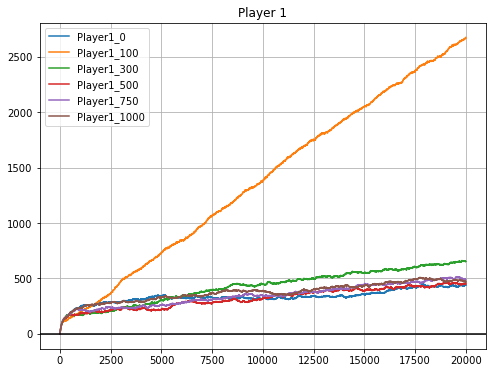

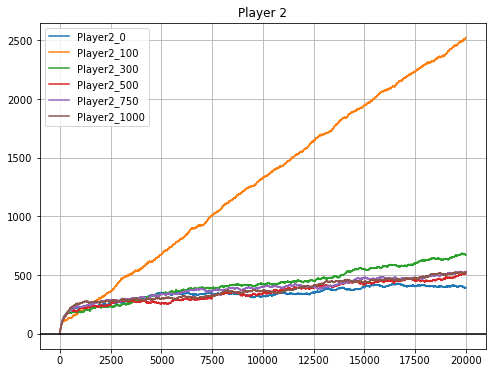

In [132]:
data = pd.read_csv('2_UCB1_Dirichlet_Base_2.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [57]:
n_arms = 10
beta = 2
n_variables = 10
conc = 10
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Uniform'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:18:20<00:00, 783.48s/it]


In [58]:
n_arms = 10
beta = 2
n_variables = 10
conc = 0.1
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCB1_Dirichlet_Degenerate'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, conc = conc, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:18:15<00:00, 782.51s/it]


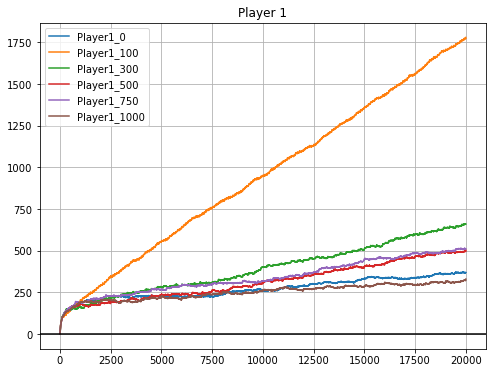

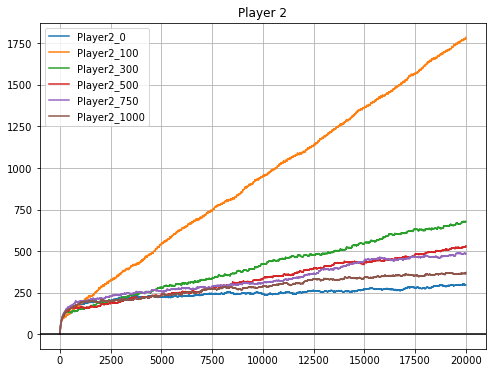

In [59]:
data = pd.read_csv('2_UCB1_Dirichlet_Base.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

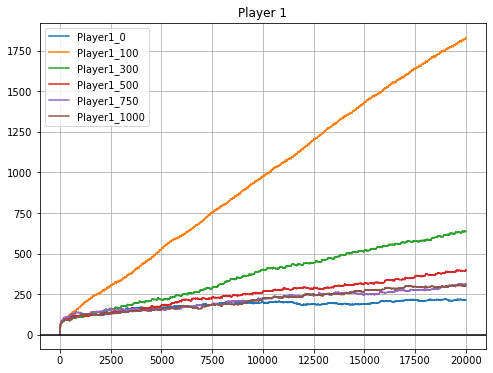

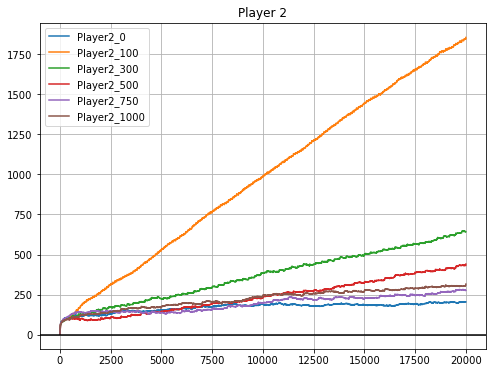

In [60]:
data = pd.read_csv('2_UCB1_Dirichlet_Degenerate.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

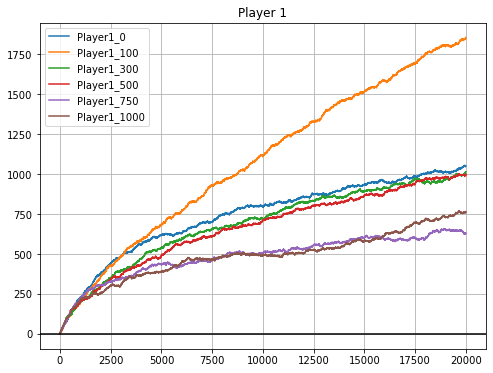

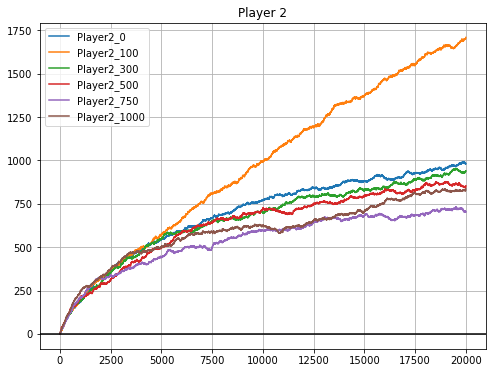

In [61]:
data = pd.read_csv('2_UCB1_Dirichlet_Uniform.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Bernoulli

In [62]:
n_arms = 10
beta = 1
n_variables = 2
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Bernoulli'
title = 'UCB1_Bernoulli'

multiple_ucb_1(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:18:17<00:00, 782.94s/it]


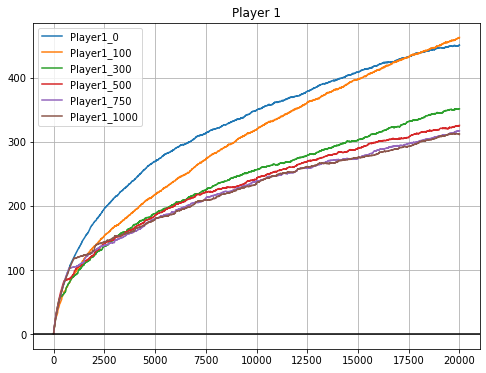

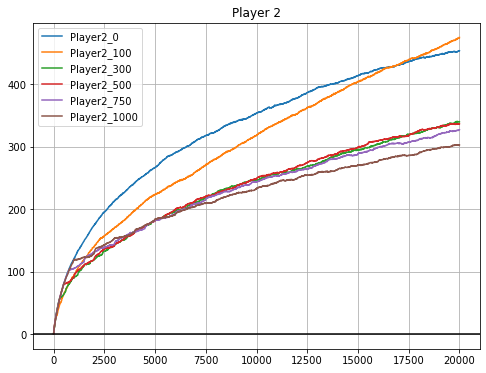

In [63]:
data = pd.read_csv('2_UCB1_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Poisson

In [64]:
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
    
n_arms = 10
beta = 2
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'UCB1_Poisson_1'
lambdas = np.arange(1,11,1)

multiple_ucb_1(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:01:26<00:00, 614.46s/it]


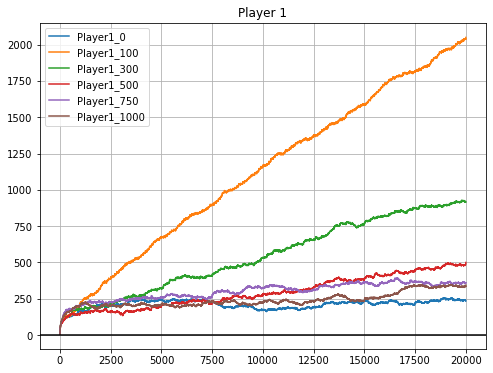

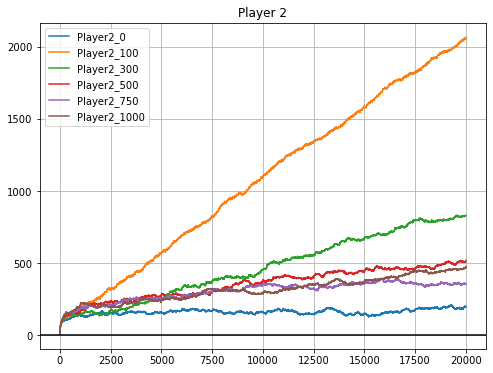

In [65]:
data = pd.read_csv('2_UCB1_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [68]:
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
    
n_arms = 10
beta = 4
n_players = 2
n_iterations = 50
dist = 'Exponential'
title = 'UCB1_Exponential_1'
lambdas = np.arange(1,11,1)

multiple_ucb_1(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:10:13<00:00, 702.22s/it]


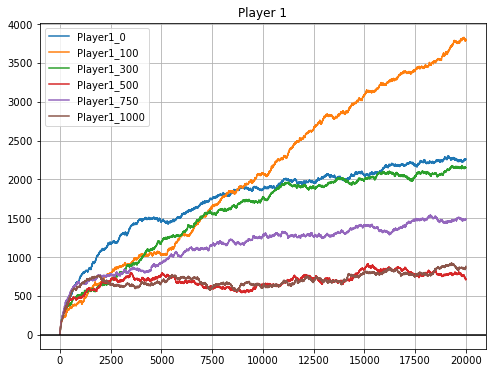

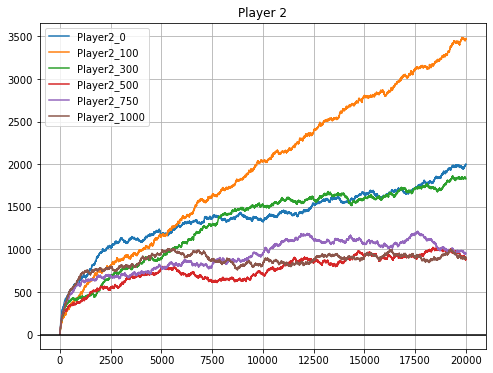

In [69]:
data = pd.read_csv('2_UCB1_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# UCB-V

In [74]:
class ucb_v_player(player_m):
    def __init__(self, n_arms, beta, player_index, n_players, n_rounds):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.beta = beta
        self.ucbs = np.zeros(shape = n_arms)
        self.variances = np.zeros(shape = n_arms)
        self.means_squared = np.zeros(shape = n_arms)
    
    def compute_ucbs(self, current_round):
        ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
        ucb_2 = 3*np.log(current_round)*self.beta/self.n_trials[self.n_trials > 0]
        self.ucbs[self.n_trials > 0] = ucb_1 + ucb_2
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice
    
    def receive_reward(self, other_reward):
        self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
        self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
        self.means_squared = (self.all_rewards**2).sum(axis = 2).sum(axis = 1)/self.n_trials
    
    def update_mean(self, choice, reward, current_round):
        if choice != None:
            self.all_rewards[choice, self.player_index, current_round] = reward
            increment = (reward - self.means[choice])/self.n_trials[choice]
            self.means[choice] += increment
            increment_squared = (reward**2 - self.means_squared[choice])/self.n_trials[choice]
            self.means_squared[choice] += increment_squared
    
    def update_variance(self, choice):
        self.variances[choice] = self.means_squared[choice] - self.means[choice]**2

In [75]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Base'
conc = 0.5
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:10:59<00:00, 1309.99s/it]


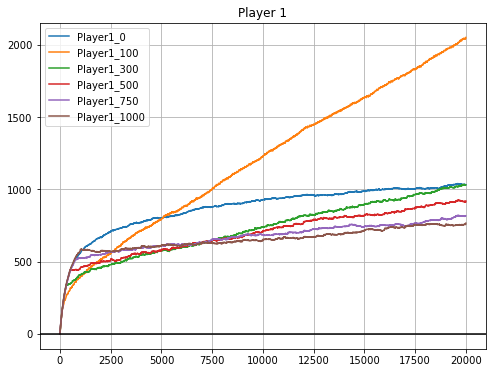

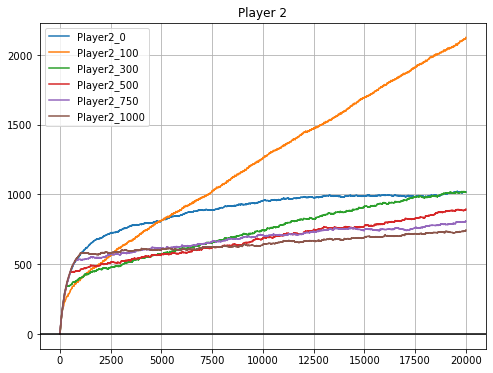

In [76]:
data = pd.read_csv('2_UCBV_Dirichlet_Base.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [78]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000] 
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Degenerate'
conc = 0.1
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:37:11<00:00, 972.00s/it]


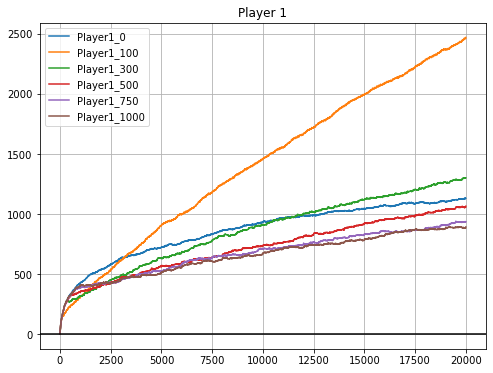

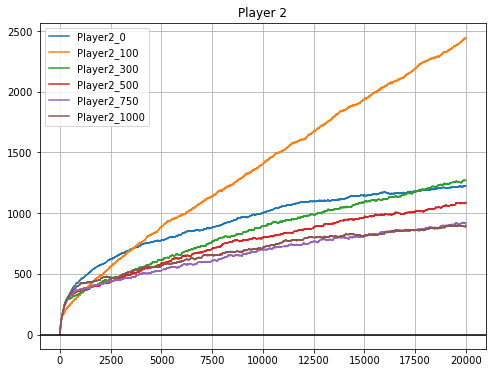

In [79]:
data = pd.read_csv('2_UCBV_Dirichlet_Degenerate.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [135]:
n_arms = 10
n_variables = 10
beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 100
dist = 'Dirichlet'
title = 'UCBV_Dirichlet_Uniform'
conc = 10
player_type = 'ucbv'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [3:39:47<00:00, 2197.95s/it]


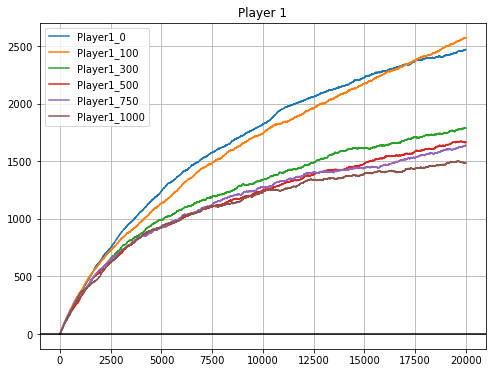

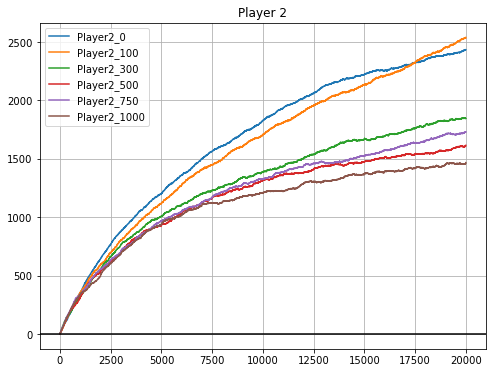

In [136]:
data = pd.read_csv('2_UCBV_Dirichlet_Uniform.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Bernoulli

In [82]:
n_arms = 10
beta = 0
n_variables = 2
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Bernoulli'
title = 'UCBV_Bernoulli'
player_type = 'ucbv'

multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, player_type = player_type, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [1:45:26<00:00, 1054.45s/it]


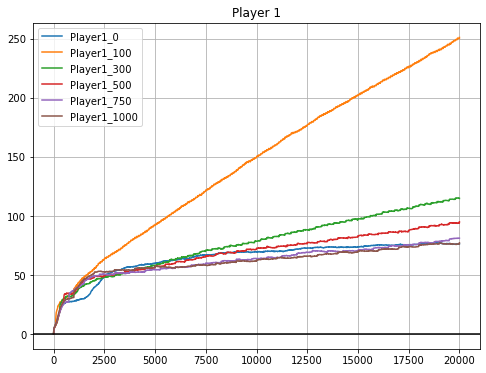

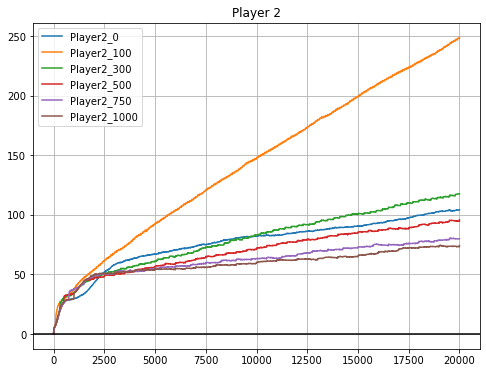

In [83]:
data = pd.read_csv('2_UCBV_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Poisson & Exponential

In [13]:
n_arms = 10
beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'UCBV_Poisson_1'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, lambdas = lambdas)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [28:21<00:00, 283.55s/it]


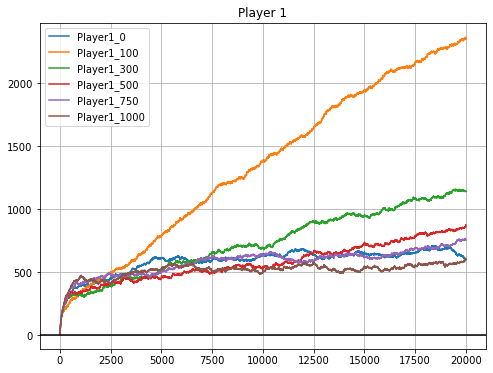

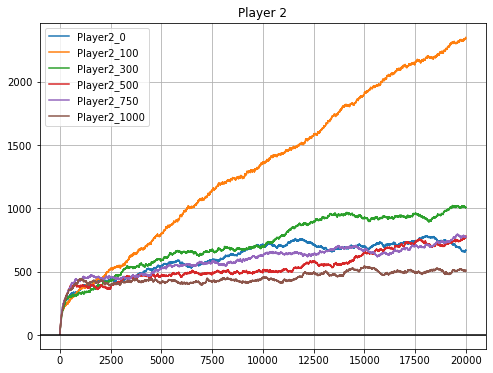

In [90]:
data = pd.read_csv('2_UCBV_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [133]:
n_arms = 10
beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 100
dist = 'Exponential'
title = 'UCBV_Exponential_1'
player_type = 'ucbv'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, beta = beta, dist = dist, player_type = player_type, lambdas = lambdas)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:49:57<00:00, 1699.63s/it]


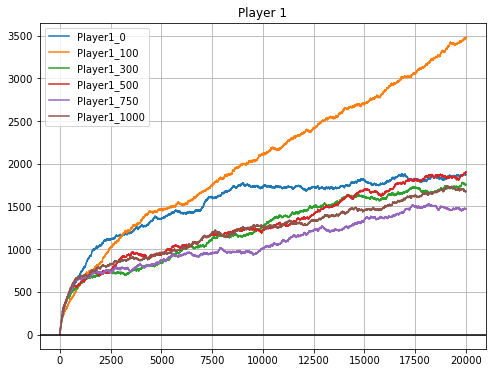

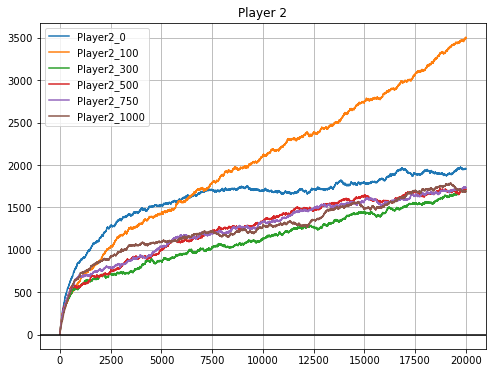

In [134]:
data = pd.read_csv('2_UCBV_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# UCB MOSS

In [15]:
class ucb_moss_player(player_m):
    def __init__(self, n_arms, player_index, n_players, n_rounds, beta):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.ucbs = np.zeros(shape = n_arms)
        self.n_rounds = n_rounds
        self.n_arms = n_arms
        self.beta = beta
        
    def compute_ucbs(self, current_round):
        log_arg = self.n_rounds/self.n_arms*self.n_trials[self.n_trials > 0]
        log_arg[log_arg < 1] = 1
        self.ucbs[self.n_trials > 0] = np.sqrt((self.beta/self.n_trials[self.n_trials > 0])*np.log(log_arg))
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice

In [84]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBMOSS_Dirichlet_Base'
conc = 0.5
player_type = 'moss'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:37:24<00:00, 974.08s/it]


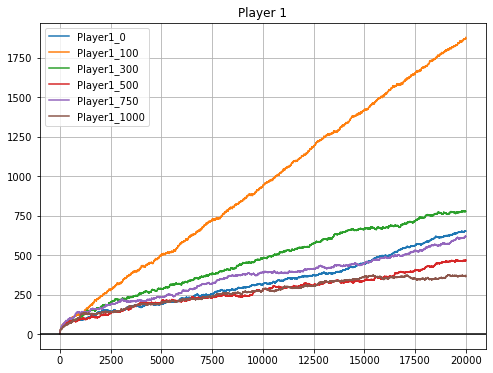

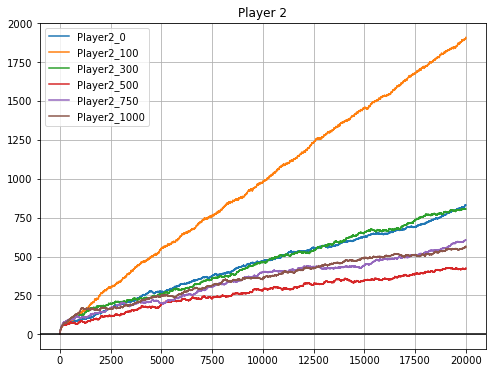

In [85]:
data = pd.read_csv('2_UCBMOSS_Dirichlet_Base.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [86]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBMOSS_Dirichlet_Degenerate'
conc = 0.1
player_type = 'moss'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:35:08<00:00, 951.35s/it]


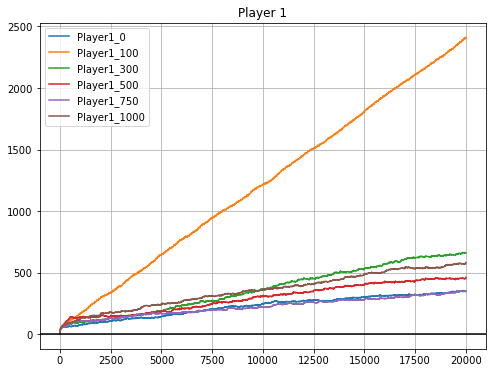

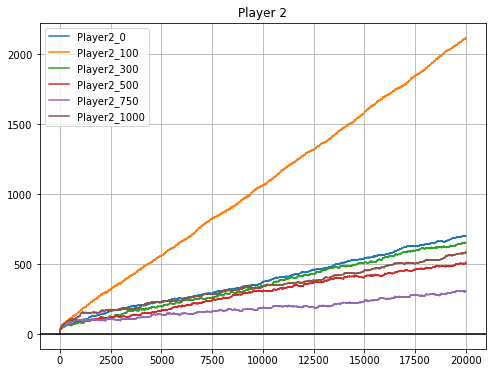

In [87]:
data = pd.read_csv('2_UCBMOSS_Dirichlet_Degenerate.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [88]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'UCBMOSS_Dirichlet_Uniform'
conc = 10
player_type = 'moss'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:37:44<00:00, 977.47s/it]


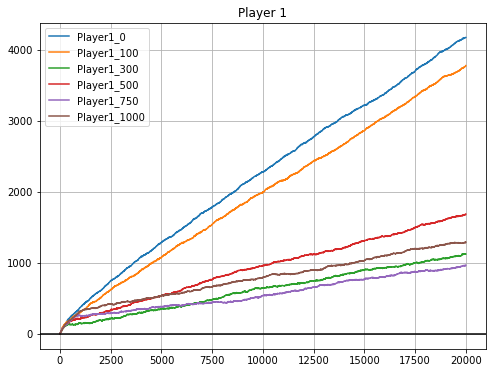

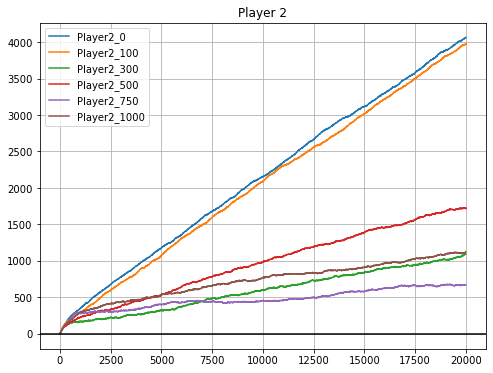

In [89]:
data = pd.read_csv('2_UCBMOSS_Dirichlet_Uniform.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Bernoulli

In [93]:
n_arms = 10
n_variables = 2
n_rounds = 20000
n_players = 2
n_iterations = 50
dist = 'Bernoulli'
title = 'UCBMOSS_Bernoulli'
player_type = 'moss'

multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [1:51:52<00:00, 1118.68s/it]


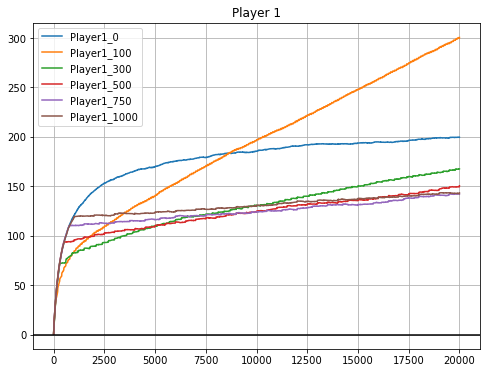

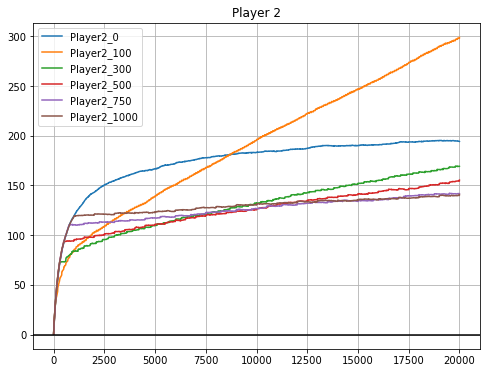

In [94]:
data = pd.read_csv('2_UCBMOSS_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Poisson & Exponential

In [95]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'UCBMOSS_Poisson_1'
player_type = 'moss'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:22:20<00:00, 823.34s/it]


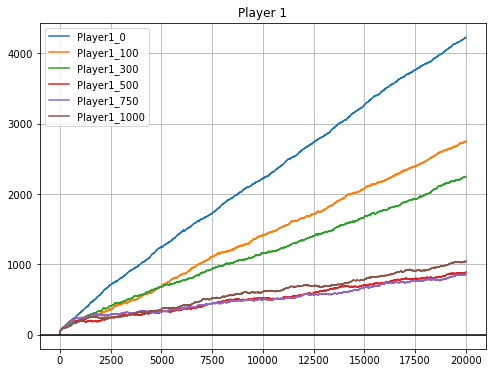

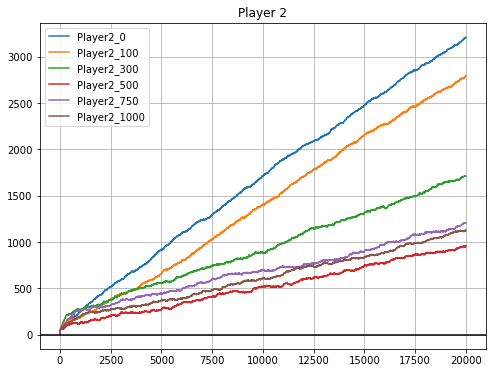

In [96]:
data = pd.read_csv('2_UCBMOSS_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [97]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Exponential'
title = 'UCBMOSS_Exponential_1'
player_type = 'moss'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:12:31<00:00, 725.19s/it]


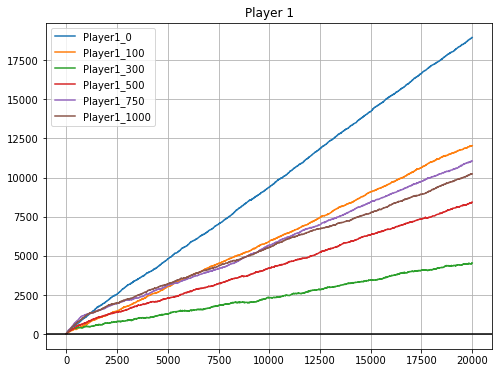

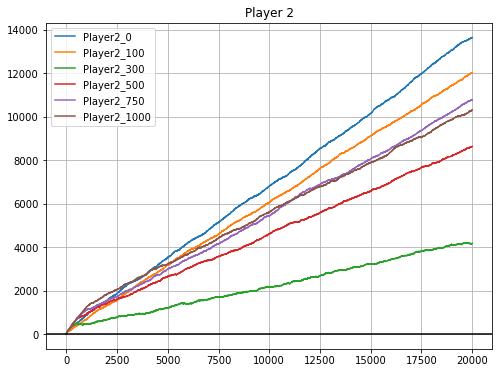

In [98]:
data = pd.read_csv('2_UCBMOSS_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# UCB-KL

In [10]:
class ucb_kl_player(player_m):
    def __init__(self, n_arms, player_index, n_players, n_rounds, dist):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.dist = dist
        self.ucbs = np.zeros(shape = n_arms)
        
    def compute_ucbs(self, current_round, l_rate, max_iter):
        if self.dist == 'Bernoulli':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                if self.means[i] == 1:
                    self.means[i] = 0.99
                maximizer = kl_bern_max(q0 = self.means[i], p = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i])
                self.ucbs[i] = maximizer
                
        elif self.dist == 'Poisson':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                maximizer = kl_pois_max(l0 = self.means[i], l1 = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i], upper_bound = 1000)
                self.ucbs[i] = maximizer
        
        elif self.dist == 'Exponential':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                maximizer = kl_exp_max(l0 = self.means[i] + 1, l1 = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i], upper_bound = 1000)
                self.ucbs[i] = maximizer
            
    def choice(self):
        choice = np.argmax(self.ucbs)
        self.choices.append(choice)
        return choice

## Bernoulli

In [30]:
n_arms = 10
n_variables = 2
n_rounds = 20000
n_players = 2
n_iterations = 25
dist = 'Bernoulli'
title = 'UCBKL_Bernoulli'
player_type = 'ucbkl'

multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [1:52:26<00:00, 1124.41s/it]


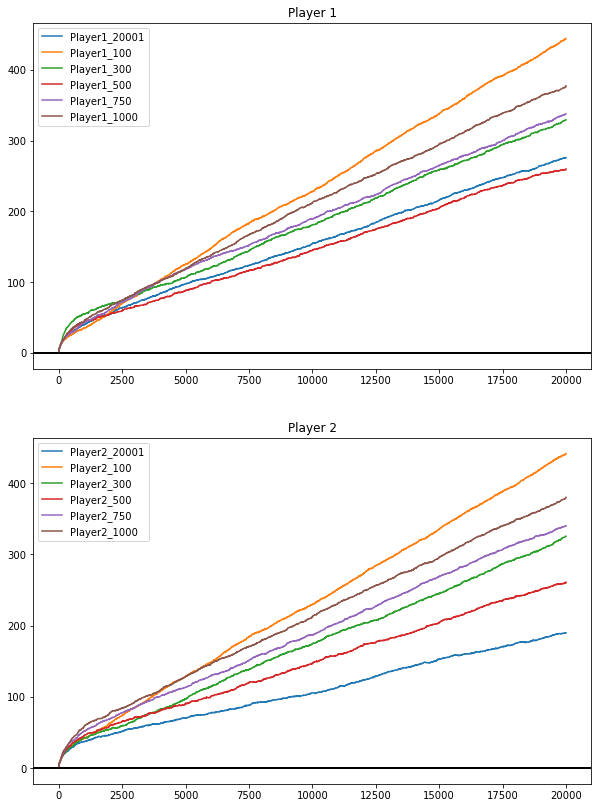

In [78]:
data = pd.read_csv('2_UCBKL_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

## Poisson & Exponential

In [31]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 25
dist = 'Poisson'
title = 'UCBKL_Poisson_1'
player_type = 'ucbkl'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type,  lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:07:59<00:00, 679.94s/it]


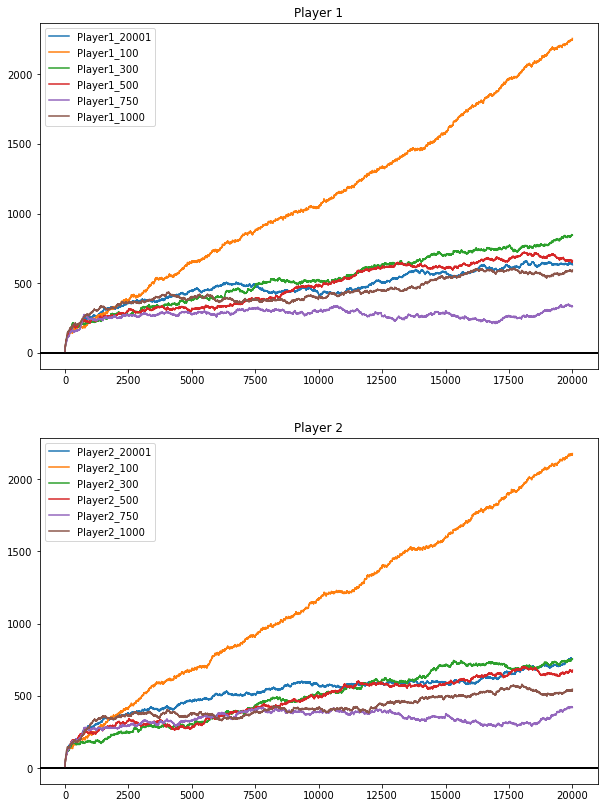

In [80]:
data = pd.read_csv('2_UCBKL_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [32]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 25
dist = 'Exponential'
title = 'UCBKL_Exponential_1'
player_type = 'ucbkl'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:06:11<00:00, 661.95s/it]


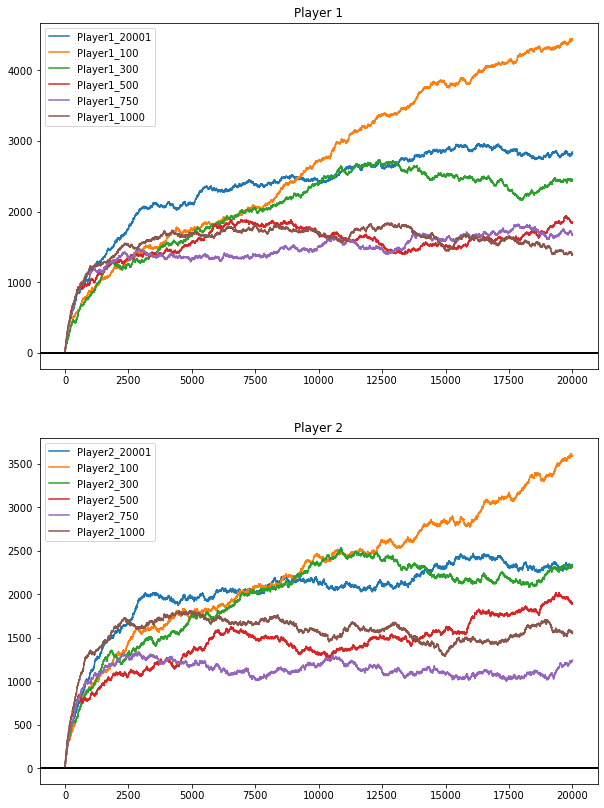

In [81]:
data = pd.read_csv('2_UCBKL_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# UCB-Bayes

In [18]:
class bayes_player(player_m):
    def __init__(self, n_arms, player_index, n_players, n_rounds, dist, scale = 1, shape = 1):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.ucbs = np.zeros(shape = n_arms)
        self.dist = dist
        self.a = np.ones(shape = n_arms)
        self.b = np.ones(shape = n_arms)
        self.shape = np.array([shape for i in range(n_arms)])
        if dist == 'Exponential':
            self.scale = [1/scale for i in range(n_arms)]
        else:
            self.scale = [scale for i in range(n_arms)]
        self.all_samples = np.zeros(shape  = (n_arms, 500))
        self.first_scale = 1/scale
        self.first_shape = shape
    
    def choice(self):
        if dist != 'Exponential':
            choice = np.argmax(self.ucbs)
        else:
            choice = np.argmin(self.ucbs)
        self.choices.append(choice)
        return choice
    
    def compute_ucbs(self, current_round):
        if self.dist == 'Bernoulli':
            for i in range(self.n_arms):
                self.ucbs[i] = beta.ppf(a = self.a[i], b = self.b[i], q = 1 - 1/current_round)
        elif self.dist == 'Poisson':
            for i in range(self.n_arms):
                self.ucbs[i] = gamma.ppf(a = self.shape[i], scale = 1/self.scale[i], q =  1 - 1/current_round)
        elif self.dist == 'Exponential':
            for i in range(self.n_arms):
                self.ucbs[i] = gamma.ppf(a = self.shape[i], scale = 1/self.scale[i], q = 1/current_round)
        elif self.dist == 'Dirichlet':
            for i in range(self.n_arms):
                p_generator = np.random.default_rng()
                probs = p_generator.dirichlet(alpha = self.alphas[i])
                self.ucbs[i] = np.random.choice(np.arange(1,11), p = probs)
            
    
    def update_params(self, choice, reward):
        if self.dist == 'Bernoulli':
            if reward == 0:
                self.b[choice] += 1
            else:
                self.a[choice] += 1
            #self.all_samples[choice, :] = np.random.beta(a = self.a[choice], b = self.b[choice], size = 5000)

        elif self.dist == 'Poisson':
            self.shape[choice] += reward
            self.scale[choice] += 1
            #self.scale[choice] = float(self.scale[choice]/(self.scale[choice] + 1))
            #self.all_samples[choice, :] = np.random.negative_binomial(self.shape[choice], 1/(self.scale[choice] + 1), size = 1000)
            #self.all_samples[choice, :] = np.random.gamma(shape = self.shape[choice], scale = 1/self.scale[choice], size = 5000)
        elif self.dist == 'Exponential':
            self.shape[choice] += 1
            self.scale[choice] += reward
            #self.all_samples[choice, :] = lomax.rvs(c = self.shape[choice], scale = self.scale[choice], size = 1000)
            #self.all_samples[choice, :] = 1/np.random.gamma(shape = self.shape[choice], scale = 1/self.scale[choice], size = 5000)
            
        elif self.dist == 'Dirichlet':
            self.alphas[choice][reward-1] += 1
            
    def receive_n_trials(self, other_trials):
        if self.dist == 'Poisson':
            self.diff = self.all_trials[(self.all_trials == 0) & (other_trials == 1)].sum()
        self.all_trials[(self.all_trials == 0) & (other_trials == 1)] = 1
        self.n_trials = self.all_trials.sum(axis = 2).sum(axis =  1)
            
    def receive_reward(self, other_reward):
        self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
        self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
        if self.dist == 'Bernoulli':
            self.a = self.all_rewards.sum(axis = 2).sum(axis = 1)
            self.a[self.a == 0] = 1
            self.b = self.n_trials - self.a
            self.b[self.b <= 0] = 1
        elif self.dist == 'Poisson':
            self.scale = self.n_trials + self.first_scale
            self.shape = self.all_rewards.sum(axis = 2).sum(axis = 1) + self.first_shape
            self.shape[self.shape == 0] = 1
        elif self.dist == 'Exponential':
            self.shape = self.n_trials + self.first_shape
            self.scale = self.all_rewards.sum(axis = 2).sum(axis = 1) + self.first_scale

In [23]:
n_arms = 10
n_rounds = 2000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 1
n_variables = 2
dist = 'Bernoulli'
title = 'UCBBayes_Bernoulli'
player_type = 'bayes'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:35<00:00, 25.96s/it]


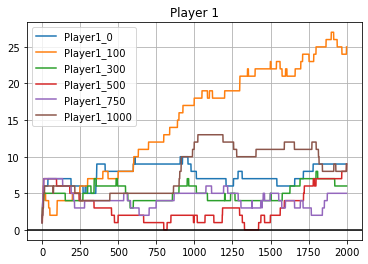

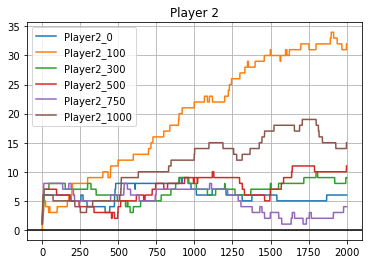

In [24]:
data = pd.read_csv('2_UCBBayes_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [25]:
n_arms = 10
n_rounds = 2000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 1
dist = 'Poisson'
title = 'UCBBayes_Poisson_1'
player_type = 'bayes'
lambdas = np.arange(1,11,1)
scale = 1
shape = 5

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, scale = scale, shape = shape, lambdas = lambdas)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:03<00:00, 20.66s/it]


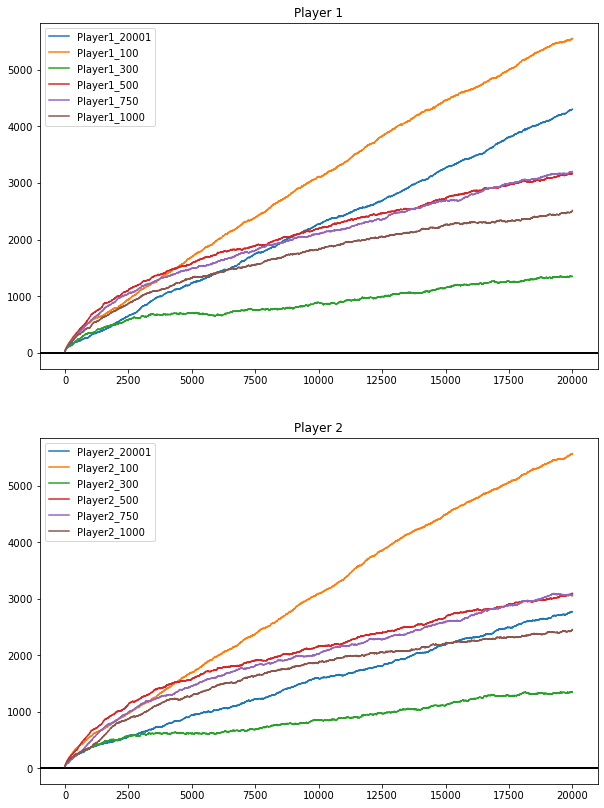

In [14]:
data = pd.read_csv('2_UCBBayes_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [15]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 25
dist = 'Exponential'
title = 'UCBBayes_Exponential_1'
player_type = 'bayes'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, lambdas = lambdas)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [5:40:34<00:00, 3405.83s/it]


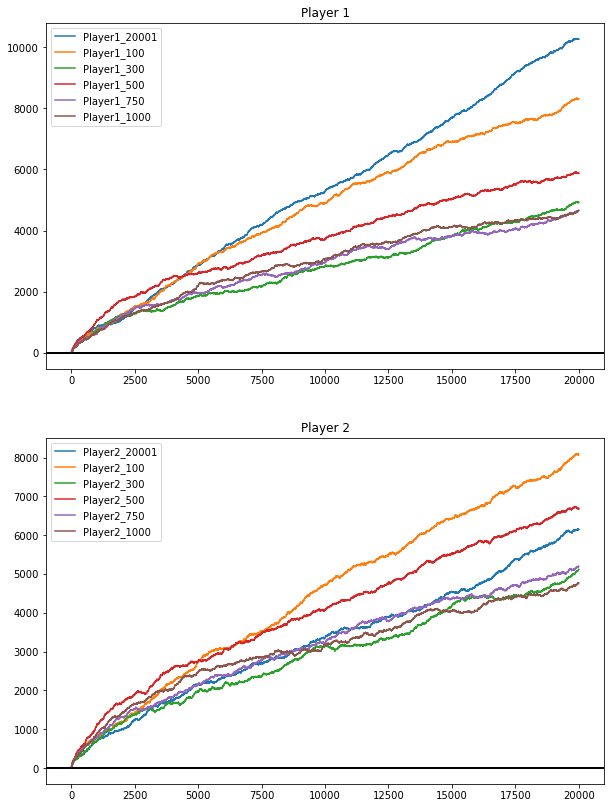

In [16]:
data = pd.read_csv('2_UCBBayes_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# Thompson Sampling

In [100]:
class thom_player(player_m):
    def __init__(self, n_arms, player_index, n_players, n_rounds, dist, ub = 0, lb = 1):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.a = np.ones(shape = n_arms)
        self.b = np.ones(shape = n_arms)
        self.dist = dist
        self.lb = lb
        self.ub = ub
        
    def choice(self):
        samples = [np.random.beta(a = self.a[i], b = self.b[i]) for i in range(self.n_arms)]
        choice = np.argmax(samples)
        self.choices.append(choice)
        return choice

    def normalize(self, reward):
        if reward > self.ub:
            self.ub = reward
        elif reward < self.lb:
            self.lb = reward
        reward = (reward - self.lb)/(self.ub - self.lb)
        return reward

    def update_params(self, choice, reward):
        if choice != None:
            if self.dist == 'Bernoulli':
                if reward == 1:
                    self.a[choice] += 1
                else:
                    self.b[choice] += 1     
            else:
                u = np.random.uniform(0,1)
                if u <= reward:
                    self.a[choice] += 1
                else:
                    self.b[choice] += 1

    def receive_reward(self, other_reward):
        self.all_rewards[(self.all_rewards == 0) & (other_reward != 0)] = other_reward[(self.all_rewards == 0) & (other_reward != 0)]
        self.means = self.all_rewards.sum(axis = 2).sum(axis = 1)/self.n_trials
        if self.dist == 'Bernoulli': 
            self.a = self.all_rewards.sum(axis = 2).sum(axis = 1) + 1
            self.b = self.n_trials - self.a + 1
            self.b[self.b <= 0] = 1
        else:
            self.norm_rewards = (self.all_rewards - self.lb)/(self.ub - self.lb)
            u = np.random.uniform(0,1)
            self.a = (u <= self.norm_rewards).sum(axis = 2).sum(axis = 1) + 1
            self.b = (u > self.norm_rewards).sum(axis = 2).sum(axis = 1) + 1

In [101]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'Thompson_Dirichlet_Base'
conc = 0.5
player_type = 'thom'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:31:41<00:00, 1516.91s/it]


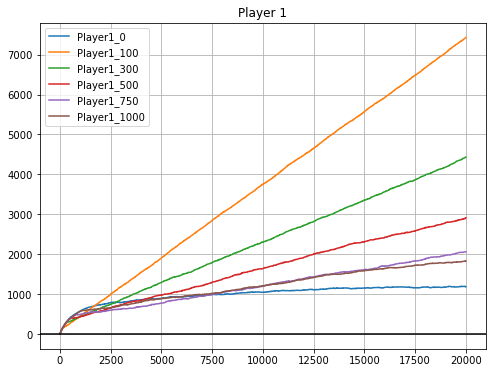

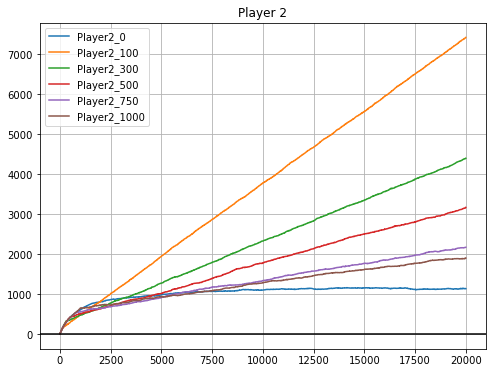

In [102]:
data = pd.read_csv('2_Thompson_Dirichlet_Base.csv').drop('Unnamed: 0', axis = 1) 
two_regrets(data)

In [103]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'Thompson_Dirichlet_Degenerate'
conc = 0.1
player_type = 'thom'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:22:08<00:00, 1421.40s/it]


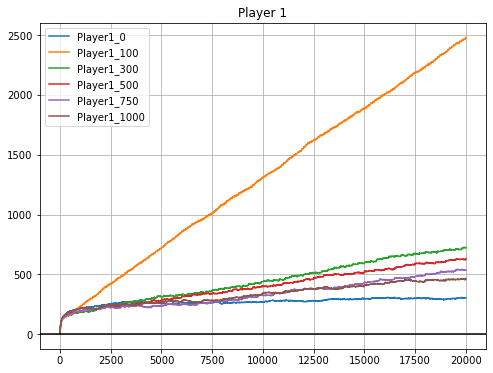

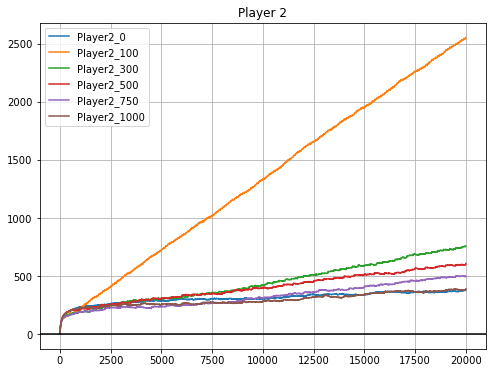

In [104]:
data = pd.read_csv('2_Thompson_Dirichlet_Degenerate.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [105]:
n_arms = 10
n_variables = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'Thompson_Dirichlet_Uniform'
conc = 10
player_type = 'thom'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:05:20<00:00, 1253.43s/it]


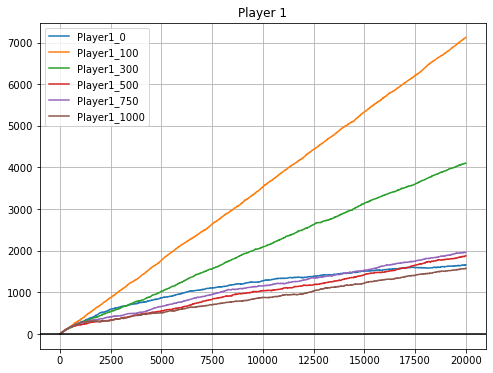

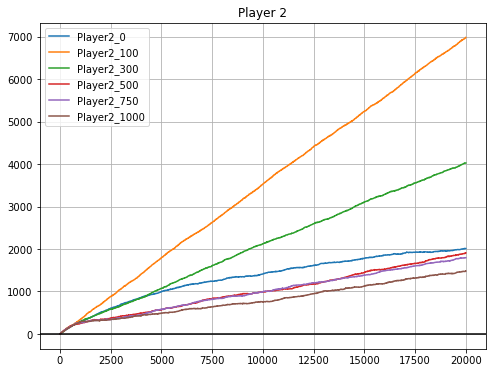

In [106]:
data = pd.read_csv('2_Thompson_Dirichlet_Uniform.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [107]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
n_variables = 2
dist = 'Bernoulli'
title = 'Thompson_Bernoulli'
player_type = 'thom'
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:39:54<00:00, 999.09s/it]


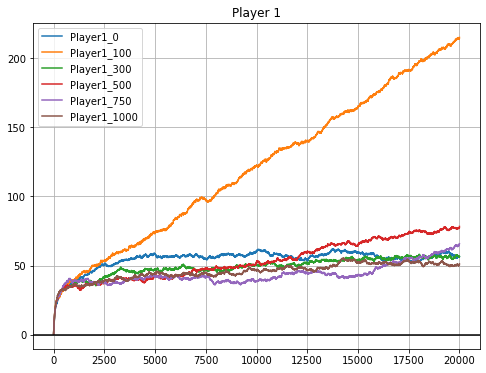

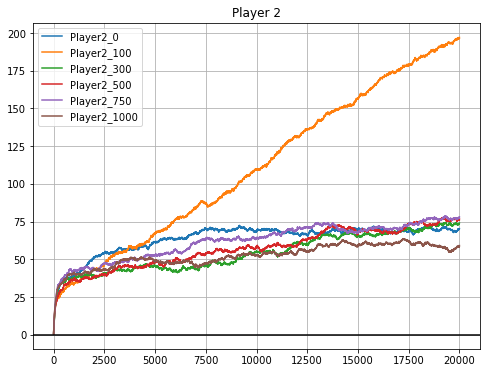

In [108]:
data = pd.read_csv('2_Thompson_Bernoulli.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [109]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Poisson'
title = 'Thompson_Poisson_1'
player_type = 'thom'
lambdas = np.arange(1,11,1)

multiple_experiment(n_arms = n_arms, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title,  dist = dist, player_type = player_type, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:25:19<00:00, 853.27s/it]


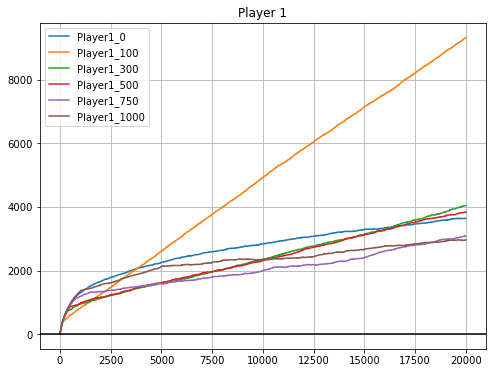

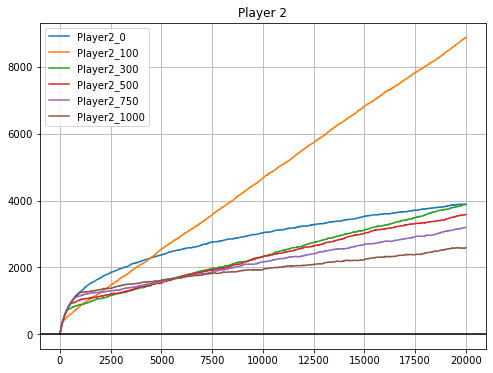

In [110]:
data = pd.read_csv('2_Thompson_Poisson_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

In [111]:
n_arms = 10
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
n_variables = 2
dist = 'Exponential'
title = 'Thompson_Exponential_1'
player_type = 'thom'
lambdas = np.arange(1,11,1)
multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, lambdas = lambdas)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:36:09<00:00, 961.64s/it]


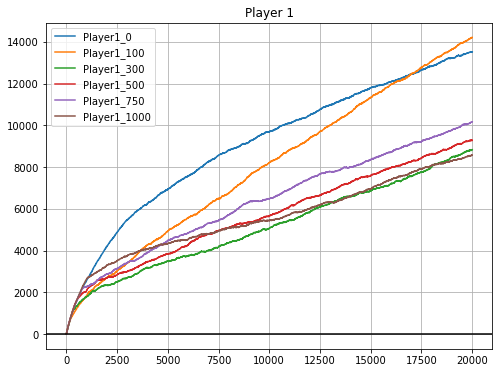

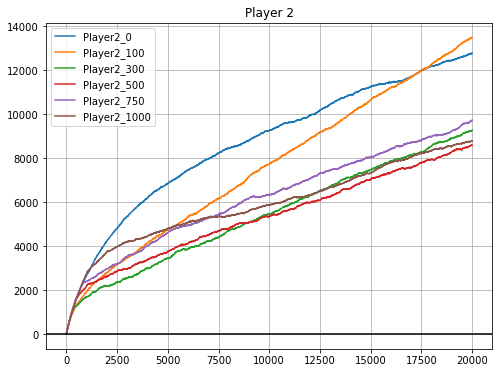

In [112]:
data = pd.read_csv('2_Thompson_Exponential_1.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)

# Epsilon-Greedy

In [28]:
def decay_prob(d):
    return lambda t: (t**(d))*((10*np.log(t))**(1/3))

In [113]:
class eps_player(player_m):
    def __init__(self, n_arms, player_index, n_players, n_rounds, prob):
        super().__init__(n_arms, player_index, n_players, n_rounds)
        self.exps = []
        self.prob = prob
        
    def exp_vs_exp(self, current_round):
        if type(self.prob) == float:
            eps = self.prob
        else:
            eps = self.prob(current_round)
        u = np.random.uniform(0,1)
        if u <= eps:
            self.exps.append('Exploration')
            return 'Exploration'
        else:
            self.exps.append('Exploitation')
            return 'Exploitation'
        
    def choice(self, exp):
        if exp == 'Exploration':
            choice = np.random.choice(np.arange(self.n_arms))
        else:
            choice = np.argmax(self.means)
        self.choices.append(choice)
        return choice

In [114]:
n_arms = 10
n_variables = 10
#beta = 1
n_rounds = 20000
all_nums = [100, 300, 500, 750, 1000]
com_freqs = [[n_rounds + 1 for i in range(n_rounds)]]
for n in all_nums:
    com_freqs.append([n + i*n for i in range(n_rounds//n)])
n_players = 2
n_iterations = 50
dist = 'Dirichlet'
title = 'Eps_Dirichlet_Base'
conc = 0.5
player_type = 'eps'
d = -0.7

multiple_experiment(n_arms = n_arms, n_variables = n_variables, n_players = n_players, n_rounds = n_rounds, n_iterations = n_iterations, com_freqs = com_freqs, title = title, dist = dist, player_type = player_type, conc = conc, d = d)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:10:05<00:00, 1300.94s/it]


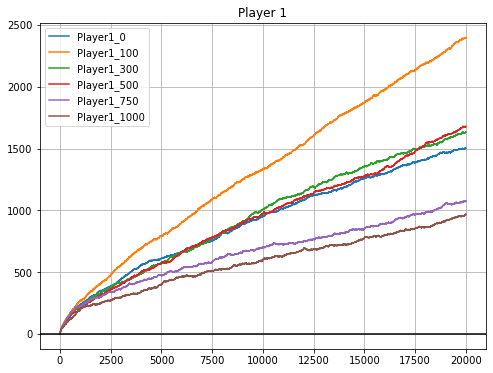

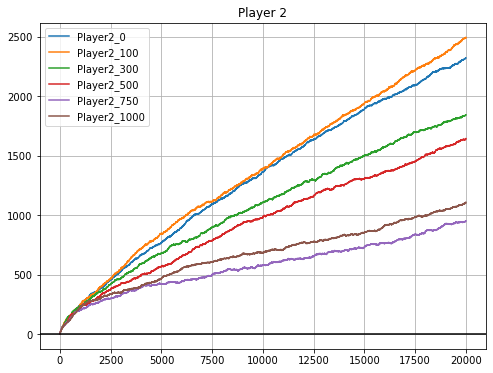

In [115]:
data = pd.read_csv('2_Eps_Dirichlet_Base.csv').drop('Unnamed: 0', axis = 1)
two_regrets(data)